## Testbench Bram and XADC


Insure that A0 is connected to -DIR and A1 is connected to -PULS on the motor driver

A4 and A5 are normal Analog input with a max of 3.3 V

A6 and A7 are the diffirential analog input AD12 and has a max differntial of 1V (A6) to Ground (A7)

In [63]:
from pynq import Overlay   ## 
from pynq import PL
from pynq import GPIO 

import numpy as np
#from pynq import allocate
from pynq import mmio ## from https://pynq.readthedocs.io/en/v2.1/pynq_libraries/mmio.html#example

import pandas as pd ## https://www.geeksforgeeks.org/python/different-ways-to-create-pandas-dataframe/
from time import time


## load overlay
ol = Overlay("CLoop_XADC_Mctrl_Bram.bit")
print(PL.bitfile_name) ## test if overlay loaded

## Load bram memmory Controller
bram = ol.axi_bram_ctrl_0

## load xadc memmory access
xadc = ol.xadc_wiz_0.mmio.array ## Based on https://discuss.pynq.io/t/how-to-read-adc-data-when-i-use-custom-overlay/6563


/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlays/CLoop_XADC_Mctrl_Bram/CLoop_XADC_Mctrl_Bram.bit


In [64]:

GO0 = GPIO(GPIO.get_gpio_pin(0), 'out') ## DIR refference point

GOF0 = GPIO(GPIO.get_gpio_pin(1), 'out') ## 12 bit ForceIN signal for connection testing
GOF1 = GPIO(GPIO.get_gpio_pin(2), 'out')
GOF2 = GPIO(GPIO.get_gpio_pin(3), 'out')
GOF3 = GPIO(GPIO.get_gpio_pin(4), 'out')


In [65]:
GO0.write(0)## dir ref
## test signal
GOF0.write(0)
GOF1.write(0)
GOF2.write(1)
GOF3.write(0)


In [66]:
## based on https://realpython.com/python-bitwise-operators/#bit-strings-in-python
## only works for correct bit size limits on ints
ibs31 = int(0b10000000000000000000000000000000)
ibs30 = int(0b01000000000000000000000000000000)
ibs22 = int(0b00000000100000000000000000000000)
ibs21 = int(0b00000000010000000000000000000000)
ibs20 = int(0b00000000001000000000000000000000)
ibs18 = int(0b00000000000001000000000000000000)
ibs12 =                    int(0b1000000000000)
ibs11 =                     int(0b100000000000)
ibs10 =                      int(0b10000000000)
ibs9  =                       int(0b1000000000)
ibs8  =                        int(0b100000000)
ibs7  =                         int(0b10000000)
ibs6  =                          int(0b1000000)
ibs5  =                           int(0b100000)
ibs4  =                            int(0b10000)
ibs3  =                             int(0b1000)
ibs2  =                              int(0b100)
ibs1  =                               int(0b10)
ibs0  =                                int(0b1)
b15t4 =                 int(0b1111111111110000)
SGcb  = int(0b01111111111111111111110000000000)
SC0cb = int(0b00000000000000000000001111111111)
SC1cb = int(0b11111111111000000000000000000000)
FIcn  = int(0b00000000000111111111111111111111)
b11t0 = int(0b00000000000000000000111111111111)
b17t12= int(0b00000000000000111111000000000000)
b23t12= int(0b00000000111111111111000000000000)
b23t18= int(0b00000000111111000000000000000000)
b30t0 = int(ibs31-1) #2147483647

## defining read memory functions
def Read_Mem():
    Mem17 = int(bram.read(17*4))
    MemDIR = int((Mem17 & ibs31) / ibs31)
    MemSG = int(Mem17 & b30t0)
    Mem18 = int(bram.read(18*4))
    Mem19 = int(bram.read(19*4))
    MemT = int((xadc[128] & b15t4) /ibs4)*503.975/4096-273.15
    MemA4 = int((xadc[128+0x15] & b15t4) /ibs4)
    MemA5 = int((xadc[128+0x1d] & b15t4) /ibs4)
    MemAD12 = int((xadc[128+0x1c] & b15t4) /ibs4)
    
    return MemDIR, MemSG, Mem18, Mem19, MemT, MemA4, MemA5, MemAD12

#MemDIR, MemSG, Mem18, Mem19, MemT, MemA4, MemA5, MemAD12 = Read_Mem()


def Write_Mem( STEPctrl, STEPtime, RUNin):
    bram.write(5*4, int(STEPtime))
    bram.write(6*4, int(STEPctrl))
    bram.write(4*4, RUNin)
    #return RUNin
    

def Calc_Testsize(PositionBuff, MeasurmentPeriod, StepPeriod): ## only works if last PositionBuff = 0
    ttime_total = 0
    steps_total = 0
    for k in range(0, len(PositionBuff)) :
        Nsteps = abs(PositionBuff[k] - PositionBuff[k - 1])
        ttime_total = Nsteps*StepPeriod[k]/1000 + ttime_total
        steps_total = Nsteps + steps_total
        
    print("steps total: ",steps_total)
    print("Ttime total: ",steps_total)
    
    #MeasurmentPeriodinSeconds = MeasurmentPeriod/1000
    testsize = int(ttime_total/MeasurmentPeriod)+1 # +1 is for fence posting
    print("  test size: ",testsize)
    
    return MeasurmentPeriod/1000, testsize
    #MeasurmentPeriodinSeconds, testsize = Calc_Testsize(PositionBuff, MeasurmentPeriod, StepPeriod): ## only works if last PositionBuff = 0
    
def MeanTimeoff(TimeDBuff, MeasurmentPeriodinSeconds):
    for TD in range(0,len(TimeDBuff)):
        totaltimeoff = (TimeDBuff[TD] - TD*MeasurmentPeriodinSeconds)
    MTimeoff=totaltimeoff/len(TimeDBuff)
    print("Added up timeoff" ,round(totaltimeoff,8),"sec  / ",len(TimeDBuff)," = ")
    print("    Mean timeoff",round(MTimeoff,12), "sec")
    return MTimeoff, totaltimeoff
    #MTimeoff, totaltimeoff = MeanTimeoff(TimeDBuff, MeasurmentPeriodinSeconds)
    
def GPIO_Write(GWval):
    GW0 = GWval&ibs0
    GW1 = int((GWval&ibs1)/ibs1)
    GW2 = int((GWval&ibs2)/ibs2)
    GW3 = int((GWval&ibs3)/ibs3)

    GOF0.write(GW0)
    GOF1.write(GW1)
    GOF2.write(GW2)
    GOF3.write(GW3)

In [92]:
## New position codes with speed-array

UStepType = 0 # 0 for closed loop control, 1 for distance control
GPIO_Write(4) ##closed loop sensor select, #to access different Analog ports set 
                                            #A2-A5 = 2-5, Diff:67=6, 89=8, 1011=10, temp=1
                

## All tests start and end from position 0
##------------------------------------------------------- 

## n cycles (0 - 2000)

# n_cycles = 5
# UB_POS = [836+300, 300]*n_cycles
# UB_ST = [UStepType]*len(UB_POS) 
# UB_POS.append(0)
# UB_ST.append(1)

# MSperiod= [1000]*len(UB_POS) # in us (min 6 us)


## n cycles hysteresis to zero (decreasing amplitude)
# n_cycles = 5
# pos_inc = 167

# UB_POS = [] # starts with n_cycles*pos_inc, then n_cycles-1*pos_inc, and ends with 1*pos_inc
# for i in range(n_cycles):
#     UB_POS.append((n_cycles-i)*pos_inc+300)
#     UB_POS.append(300)

# UB_ST = [UStepType]*len(UB_POS) 
# UB_POS.append(0)
# UB_ST.append(1)    
# MSperiod= [1000]*len(UB_POS) # in us (min 6 us)

## n cycles hysteresis to middle (decreasing amplitude)
n_cycles = 5 # and extra cycle is added to get the middle point
pos_inc = 84
pos_max = n_cycles*2*pos_inc

UB_POS = []
for i in range(n_cycles+1):
    UB_POS.append(pos_max-i*pos_inc+300)
    UB_POS.append(i*pos_inc+300)

UB_POS[-1]=300 # Go back to 0 at the end of test (Replaces duplicate middle point)

UB_ST = [UStepType]*len(UB_POS) 
UB_POS.append(0)
UB_ST.append(1)  

MSperiod= [1000]*len(UB_POS) # in us (min 6 us)

## Different speeds: n cycles with increasing period
# n_cycles = 5
# period_min = 1000
# UB_POS = [2000, 0]*n_cycles
#UB_ST = [1]*len(UB_POS) # UStepType # 1 = distance
# MSperiod= [(i+1)*period_min for i in range(n_cycles)]
# MSperiod= [x for x in MSperiod for _ in range(2)]

## Sinusoid between 0 and sin_amp*2
# sin_n = 3 #number of sin
# sin_period=8 #in seconds
# res = 20 #resolution of each sin
# sin_amp=1000 #amplitude
# res_period=(sin_period/res)*1000000

# UB_POS=[int(sin_amp+sin_amp*np.sin(2*np.pi*(3/4+i/res))) for i in range(res)]*sin_n
# UB_POS.append(0)

# MSperiod=[]
# for i in range(len(UB_POS)-1):
#     MSperiod.append(int(res_period/np.abs(UB_POS[i+1]-UB_POS[i])))

# UB_POS = UB_POS[1:]

#UB_ST = [1]*len(UB_POS) # UStepType # 1 = distance

# print(UB_POS)
# print(MSperiod)



#------------------------------------------------------

MAXF  = 30000 ## not functional

if min(MSperiod) < 6: 
    print("Error min Step Period is 6 us > current MSperiod =", min(MSperiod), "us")
else:
    inputUB0 = np.zeros(len(UB_POS), dtype=np.uint32)
    inputUB1 = np.zeros(len(UB_POS), dtype=np.uint32)
    
    MAXF0 = int((MAXF)/ibs11)  ##  9 -  0
    MAXF1 = MAXF % (1 << 11) ## 31 - 20

    for i in range(len(UB_POS)):
        inputUB0[i] = ibs31 + (ibs30*UB_ST[i]) + (UB_POS[i]*ibs9) + MAXF0
        inputUB1[i] = (MAXF1*ibs20) + MSperiod[i]
    print(inputUB0)
#     for k in range(len(UB_POS)): # print Bitstream for debugging
#         print(bin(inputUB0[k]))

    print(inputUB1)
#     for k in range(len(UB_POS)): # print Bitstream for debugging
#         print(bin(inputUB1[k]))

[2148067342 2147637262 2148024334 2147680270 2147981326 2147723278
 2147938318 2147766286 2147895310 2147809294 2147852302 2147637262
 3221225486]
[2785018856 2785018856 2785018856 2785018856 2785018856 2785018856
 2785018856 2785018856 2785018856 2785018856 2785018856 2785018856
 2785018856]


In [103]:
## chenck if bram is empty
for d in range(4,21):
    print("bram addr, ", d ,bram.read(d*4))
    

DIRpeek, SGpeek, CSpeek, CLpeek, Temppeek, A4peek, A5peek, AD12peek = Read_Mem()

print("   Step DIR: ", DIRpeek)
print("  Step Goal: ", SGpeek)
print("Curent Step: ", CSpeek)
print("   CL input: ", CLpeek)
print("       Temp: ", Temppeek)
print("         A4: ", A4peek)
print("         A5: ", A5peek)
print("       AD12: ", AD12peek)

bram addr,  4 0
bram addr,  5 2785018856
bram addr,  6 3221225486
bram addr,  7 0
bram addr,  8 0
bram addr,  9 0
bram addr,  10 0
bram addr,  11 0
bram addr,  12 0
bram addr,  13 0
bram addr,  14 0
bram addr,  15 0
bram addr,  16 0
bram addr,  17 0
bram addr,  18 0
bram addr,  19 10
bram addr,  20 0
   Step DIR:  0
  Step Goal:  0
Curent Step:  0
   CL input:  11
       Temp:  45.156475830078136
         A4:  10
         A5:  13
       AD12:  2769


In [94]:
## calculating the requested number of steps during the test
measperiod = 10 # ms
Smeasperiod, testsize = Calc_Testsize(UB_POS, measperiod, MSperiod) ## only works if last PositionBuff = 0
if UStepType == 0:
    testsize = 3000

TimeDiff = np.zeros(testsize)
DIRmem = np.zeros(testsize, dtype=np.uint32)
SGmem  = np.zeros(testsize, dtype=np.uint32)
CSmem  = np.zeros(testsize, dtype=np.uint32)
CLmem  = np.zeros(testsize, dtype=np.uint32)
Temp   = np.zeros(testsize, dtype=np.uint32)
A4     = np.zeros(testsize, dtype=np.uint32)
A5     = np.zeros(testsize, dtype=np.uint32)
AD12   = np.zeros(testsize, dtype=np.uint32)

data = { 
    'Time': TimeDiff,
    'Step DIR': DIRmem,
    'Step Goal' : SGmem,
    'Curent Step': CSmem,
    'CL input' : CLmem,
    'Temprature' : Temp,
    'A4' : A4,
    'A5' : A5,
    'AD12' : AD12
}


steps total:  6480
Ttime total:  6480
  test size:  649


#clears bram command
#end_iUB0 = inputUB0[i] = ibs31 + (ibs30*UB_ST) + (UB_POS[len(UB_POS)-1]*ibs9)
bram.write(5*4, int(ibs30))
bram.write(6*4, int(inputUB1[0]))
bram.write(4*4, 5)
print(len(UB_POS))

In [95]:
## running test loop
i = 0
d = 0
TimeDiff[d] = 0

#read memory
DIRmem[d], SGmem[d], CSmem[d], CLmem[d], Temp[d], A4[d], A5[d], AD12[d] = Read_Mem()
Write_Mem( inputUB0[i], inputUB1[i], 0)## loads Position 0 but doesn't Run it
d+=1
i+=1
timeold = time()
bram.write(4*4, 5) ## manual activation for time precision
timeOG = timeold

while d < len(SGmem) or i >= len(UB_POS): ## only repeat while loop for repeat 
    if  time() >= timeOG + d*Smeasperiod:
        timeold = time()
        
        DIRmem[d], SGmem[d], CSmem[d], CLmem[d], Temp[d], A4[d], A5[d], AD12[d] = Read_Mem()
        TimeDiff[d] = timeold - timeOG

        if SGmem[d] == UB_POS[i]:
            if i < len(UB_POS): 
                Write_Mem( inputUB0[i], inputUB1[i], i)
                i+=1
                
        d+=1
        
    
df = pd.DataFrame(data)
print(df)

#MTimeoff, totaltimeoff = MeanTimeoff(TimeDiff, Smeasperiod)


           Time  Step DIR  Step Goal  Curent Step  CL input  Temprature   A4  \
0      0.000000         0          0            0       264          44  264   
1      0.010009         1       1140           10       266          44  265   
2      0.020010         1       1140           20       264          45  265   
3      0.030008         1       1140           30       264          45  265   
4      0.040010         1       1140           40       266          44  267   
...         ...       ...        ...          ...       ...         ...  ...   
2995  29.950010         0          0            0       262          46  261   
2996  29.960010         0          0            0       260          46  261   
2997  29.970010         0          0            0       261          45  262   
2998  29.980007         0          0            0       261          46  260   
2999  29.990006         0          0            0       260          46  260   

      A5  AD12  
0     15   549  
1    

In [ ]:
# reset the PYNQ to IDLE, will end in Green states waiting for RUNSig = '1'
Write_Mem( int(inputUB0[i]&b30t0), inputUB1[i], i)
print(bin(inputUB0[i]))
print("",bin(inputUB0[i]&b30t0))

In [96]:

MTimeoff, totaltimeoff = MeanTimeoff(TimeDiff, Smeasperiod) # time off ideal 


Added up timeoff 6.21e-06 sec  /  3000  = 
    Mean timeoff 2.069e-09 sec


In [97]:
print(df.to_string())

           Time  Step DIR  Step Goal  Curent Step  CL input  Temprature    A4  A5  AD12
0      0.000000         0          0            0       264          44   264  15   549
1      0.010009         1       1140           10       266          44   265  15  3508
2      0.020010         1       1140           20       264          45   265  18  2374
3      0.030008         1       1140           30       264          45   265  13  1716
4      0.040010         1       1140           40       266          44   267  15  4095
5      0.050011         1       1140           50       264          45   264  17  3116
6      0.060009         1       1140           60       264          45   265  11  4095
7      0.070005         1       1140           70       262          44   265  15   443
8      0.080011         1       1140           80       265          44   264  17  1613
9      0.090009         1       1140           90       264          45   266  13  3820
10     0.100008         1       

In [102]:
df.to_csv("CLMhystb.csv", index=False)

In [99]:
import matplotlib.pyplot as plt


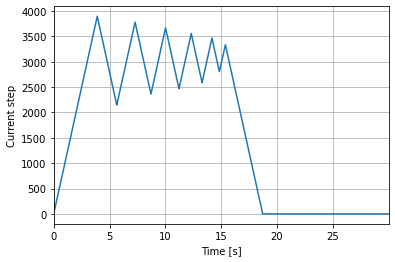

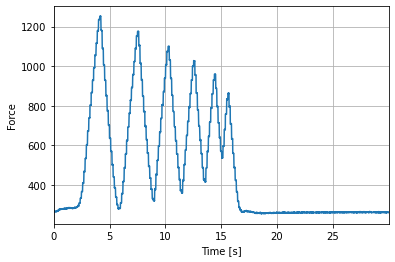

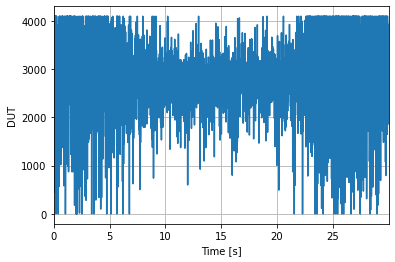

In [100]:
plt.figure()
plt.plot(df["Time"],df["Curent Step"])
plt.xlabel('Time [s]')
plt.ylabel('Current step')
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show;

plt.figure()
plt.plot(df["Time"],df["A4"])
plt.xlabel('Time [s]')
plt.ylabel('Force')
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show;

plt.figure()
plt.plot(df["Time"],df["AD12"])
plt.xlabel('Time [s]')
plt.ylabel('DUT')
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show;


In [101]:
max(df["A4"])

1252